In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

hospital_df = pd.read_csv('../downloads/normalizacion/hospital.csv', delimiter=',')
hospital_activity_df = pd.read_csv('../downloads/normalizacion/hospital_activity.csv', delimiter=';')
hospital_municipality_df = pd.read_csv('../downloads/normalizacion/hospital_municipality.csv', delimiter=';')
hospital_resources_df = pd.read_csv('../downloads/normalizacion/hospital_resources.csv', delimiter=';')
municipality_df = pd.read_csv('../downloads/normalizacion/municipality.csv', delimiter=',')
municipality_demographics_df = pd.read_csv('../downloads/normalizacion/municipality_demographics.csv', delimiter=',')

# Filtro solicitado sobre hospital_municipality_df
exclude_hospital_id = 'hospital_central_de_la_defensa_gomez_ulla'
exclude_municipality_names = ['Moratalaz', 'Vicálvaro y Retiro', 'Braojos de la Sierra', 'nan']

# Convertir municipality_id a string para evitar problemas de comparación
hospital_municipality_df['municipality_id'] = hospital_municipality_df['municipality_id'].astype(str)

# Filtrar los municipality_id nulos y vacíos
hospital_municipality_df = hospital_municipality_df[hospital_municipality_df['municipality_id'].notnull() & (hospital_municipality_df['municipality_id'] != '')]

# Filtrar por municipality_id
hospital_municipality_df = hospital_municipality_df[~hospital_municipality_df['municipality_id'].isin(exclude_municipality_names)]

# Filtrar por hospital_id
hospital_municipality_df = hospital_municipality_df[hospital_municipality_df['hospital_id'] != exclude_hospital_id]

# === NUEVO FILTRO: MUNICIPIOS CON POBLACIÓN < 50,000 HABITANTES ===
# Preparar datos demográficos para filtro poblacional
population_filter_data = municipality_demographics_df[
    (municipality_demographics_df['year'].astype(str) == '2022') &
    (municipality_demographics_df['range'] == 'total')
].copy()

# Asegurar tipos compatibles
municipality_df['id_secondary'] = municipality_df['id_secondary'].astype(str)
population_filter_data['id_secondary_municipality'] = population_filter_data['id_secondary_municipality'].astype(str)

# Crear lista de municipios con población < 50,000
municipios_pequenos = municipality_df.merge(
    population_filter_data[['id_secondary_municipality', 'total']].rename(columns={
        'id_secondary_municipality': 'id_secondary',
        'total': 'poblacion_total'
    }),
    on='id_secondary',
    how='inner'
)

# Filtrar municipios con población < 50,000
municipios_pequenos = municipios_pequenos[municipios_pequenos['poblacion_total'] < 50000]
municipios_ids_pequenos = municipios_pequenos['id'].astype(str).tolist()

# Aplicar filtro a hospital_municipality_df
print(f"📊 FILTRO POBLACIONAL APLICADO:")
print(f"   Hospitales antes del filtro: {hospital_municipality_df['hospital_id'].nunique()}")
print(f"   Municipios antes del filtro: {hospital_municipality_df['municipality_id'].nunique()}")

hospital_municipality_df = hospital_municipality_df[
    hospital_municipality_df['municipality_id'].isin(municipios_ids_pequenos)
]

print(f"   Hospitales después del filtro (población < 50,000): {hospital_municipality_df['hospital_id'].nunique()}")
print(f"   Municipios después del filtro (población < 50,000): {hospital_municipality_df['municipality_id'].nunique()}")
print(f"   Municipios con población < 50,000: {len(municipios_ids_pequenos)}")
print("="*80)

hospital_resources_2022 = hospital_resources_df[hospital_resources_df['year'].astype(str) == '2022'].copy()
hospital_resources_2022['hospital_id'] = hospital_resources_2022['hospital_id'].astype(str)

hospital_activity_2022 = hospital_activity_df[hospital_activity_df['year'].astype(str) == '2022'].copy()
hospital_activity_2022['hospital_id'] = hospital_activity_2022['hospital_id'].astype(str)

municipality_demographics_2022 = municipality_demographics_df[municipality_demographics_df['year'].astype(str) == '2022'].copy()
municipality_demographics_2022['id_secondary_municipality'] = municipality_demographics_2022['id_secondary_municipality'].astype(str)


📊 FILTRO POBLACIONAL APLICADO:
   Hospitales antes del filtro: 19
   Municipios antes del filtro: 159
   Hospitales después del filtro (población < 50,000): 14
   Municipios después del filtro (población < 50,000): 141
   Municipios con población < 50,000: 155


In [9]:
# === CÁLCULO DEL NIVEL DE SERVICIO DE HOSPITALES ===

# 1. PREPARAR DATOS DE RECURSOS POR HOSPITAL
hospital_resources_pivot = hospital_resources_2022.pivot_table(
    index='hospital_id',
    columns='type_resources',
    values='total',
    fill_value=0
).reset_index()

# 2. PREPARAR DATOS DE ACTIVIDAD POR HOSPITAL
hospital_activity_pivot = hospital_activity_2022.pivot_table(
    index='hospital_id',
    columns='type_activity',
    values='total',
    fill_value=0
).reset_index()

# 3. UNIR RECURSOS Y ACTIVIDAD POR HOSPITAL
hospital_service_df = hospital_resources_pivot.merge(hospital_activity_pivot, on='hospital_id', how='outer')

# Renombrar columnas a snake_case
column_mapping = {
    'Camas instaladas': 'camas_instaladas',
    'Estancia media global': 'estancia_media_global',
    'Ingresos programados': 'ingresos_programados',
    'Ingresos urgentes': 'ingresos_urgentes',
    'Total ingresos': 'total_ingresos',
    'Urgencias totales': 'urgencias_totales'
}
hospital_service_df = hospital_service_df.rename(columns=column_mapping)

# 4. CALCULAR INDICADORES DE NIVEL DE SERVICIO

# 4.1 Tasa de ocupación de camas (días de hospitalización / (camas * 365))
if 'camas_instaladas' in hospital_service_df.columns and 'total_ingresos' in hospital_service_df.columns and 'estancia_media_global' in hospital_service_df.columns:
    hospital_service_df['dias_hospitalizacion'] = hospital_service_df['total_ingresos'] * hospital_service_df['estancia_media_global']
    hospital_service_df['capacidad_anual_camas'] = hospital_service_df['camas_instaladas'] * 365
    hospital_service_df['tasa_ocupacion_camas'] = np.where(
        hospital_service_df['capacidad_anual_camas'] > 0,
        hospital_service_df['dias_hospitalizacion'] / hospital_service_df['capacidad_anual_camas'],
        0
    )

# 4.2 Eficiencia en urgencias (% de ingresos desde urgencias)
if 'urgencias_totales' in hospital_service_df.columns and 'total_ingresos' in hospital_service_df.columns:
    hospital_service_df['tasa_ingreso_urgencias'] = np.where(
        hospital_service_df['urgencias_totales'] > 0,
        hospital_service_df['total_ingresos'] / hospital_service_df['urgencias_totales'],
        0
    )

# 4.3 Eficiencia de ingresos urgentes vs programados
if 'ingresos_urgentes' in hospital_service_df.columns and 'ingresos_programados' in hospital_service_df.columns:
    hospital_service_df['total_ingresos_calculado'] = hospital_service_df['ingresos_urgentes'] + hospital_service_df['ingresos_programados']
    hospital_service_df['ratio_urgentes_programados'] = np.where(
        hospital_service_df['ingresos_programados'] > 0,
        hospital_service_df['ingresos_urgentes'] / hospital_service_df['ingresos_programados'],
        0
    )

# 4.4 Productividad de camas (ingresos por cama)
if 'total_ingresos' in hospital_service_df.columns and 'camas_instaladas' in hospital_service_df.columns:
    hospital_service_df['productividad_camas'] = np.where(
        hospital_service_df['camas_instaladas'] > 0,
        hospital_service_df['total_ingresos'] / hospital_service_df['camas_instaladas'],
        0
    )

# 4.5 Eficiencia de estancia (menor estancia = más eficiente, pero normalizado)
if 'estancia_media_global' in hospital_service_df.columns:
    hospital_service_df['eficiencia_estancia'] = np.where(
        hospital_service_df['estancia_media_global'] > 0,
        1 / hospital_service_df['estancia_media_global'],  # Invertir para que menor estancia = mayor eficiencia
        0
    )

# 5. CALCULAR ÍNDICE COMPUESTO DE NIVEL DE SERVICIO

# Actualizar indicadores disponibles
service_indicators = ['tasa_ocupacion_camas', 'tasa_ingreso_urgencias', 'ratio_urgentes_programados',
                     'productividad_camas', 'eficiencia_estancia']

# Crear copia para normalización
hospital_service_normalized = hospital_service_df.copy()

for indicator in service_indicators:
    if indicator in hospital_service_normalized.columns:
        # Usar percentiles para normalizar (0-100)
        hospital_service_normalized[f'{indicator}_percentile'] = hospital_service_normalized[indicator].rank(pct=True) * 100

        # Para tasa de ocupación, el óptimo está cerca del 80-85%, no al máximo
        if indicator == 'tasa_ocupacion_camas':
            # Penalizar ocupaciones muy bajas (<50%) y muy altas (>95%)
            hospital_service_normalized[f'{indicator}_score'] = np.where(
                hospital_service_normalized[indicator] < 0.5,
                hospital_service_normalized[indicator] * 2 * 100,  # Escala 0-50 para <50%
                np.where(
                    hospital_service_normalized[indicator] > 0.95,
                    100 - (hospital_service_normalized[indicator] - 0.95) * 1000,  # Penalizar >95%
                    100  # Óptimo entre 50-95%
                )
            )
        else:
            hospital_service_normalized[f'{indicator}_score'] = hospital_service_normalized[f'{indicator}_percentile']

# Calcular índice compuesto de nivel de servicio (promedio de scores disponibles)
score_columns = [col for col in hospital_service_normalized.columns if col.endswith('_score')]
if score_columns:
    hospital_service_normalized['nivel_servicio_score'] = hospital_service_normalized[score_columns].mean(axis=1, skipna=True)
else:
    hospital_service_normalized['nivel_servicio_score'] = 0

# 6. AGREGAR INFORMACIÓN DE MUNICIPIO Y NOMBRES DESCRIPTIVOS (SOLO HOSPITALES CON MUNICIPIO)
hospital_service_final = hospital_service_normalized.merge(
    hospital_municipality_df[['hospital_id', 'municipality_id']],
    on='hospital_id',
    how='inner'  # Cambio a INNER JOIN - solo hospitales con municipio asignado
)

# 6.1 Agregar nombres de hospitales
hospital_df['id'] = hospital_df['id'].astype(str)
hospital_service_final = hospital_service_final.merge(
    hospital_df[['id', 'name']].rename(columns={'id': 'hospital_id', 'name': 'hospital_name'}),
    on='hospital_id',
    how='inner'  # INNER JOIN para asegurar que tenemos nombres
)

# 6.2 Agregar nombres de municipios y datos demográficos
municipality_df['id'] = municipality_df['id'].astype(str)
hospital_service_final = hospital_service_final.merge(
    municipality_df[['id', 'name', 'id_secondary']].rename(columns={'id': 'municipality_id', 'name': 'municipality_name'}),
    on='municipality_id',
    how='inner'  # INNER JOIN para asegurar que tenemos nombres de municipio
)


In [10]:
# === ANÁLISIS DE POBLACIÓN ASIGNADA A HOSPITALES ===

# 6.3 Preparar datos demográficos (población total por municipio)
population_data = municipality_demographics_2022[
    (municipality_demographics_2022['range'] == 'total')
].copy()

# 6.4 Agregar población total del municipio a cada hospital
# Asegurar que los tipos de datos sean compatibles para el merge
municipality_df['id_secondary'] = municipality_df['id_secondary'].astype(str)
population_data['id_secondary_municipality'] = population_data['id_secondary_municipality'].astype(str)

# Hacer el merge con manejo de errores
try:
    hospital_service_final = hospital_service_final.merge(
        population_data[['id_secondary_municipality', 'total']].rename(columns={
            'id_secondary_municipality': 'id_secondary',
            'total': 'poblacion_total_municipio'
        }),
        on='id_secondary',
        how='left'
    )

except Exception as e:
    # Método alternativo: crear el merge paso a paso
    population_renamed = population_data[['id_secondary_municipality', 'total']].copy()
    population_renamed = population_renamed.rename(columns={
        'id_secondary_municipality': 'id_secondary',
        'total': 'poblacion_total_municipio'
    })

    # Asegurar tipos compatibles
    population_renamed['id_secondary'] = population_renamed['id_secondary'].astype(str)
    hospital_service_final['id_secondary'] = hospital_service_final['id_secondary'].astype(str)

    # Intentar merge nuevamente
    hospital_service_final = hospital_service_final.merge(
        population_renamed,
        on='id_secondary',
        how='left'
    )

# Rellenar valores nulos de población con 0
hospital_service_final['poblacion_total_municipio'] = hospital_service_final['poblacion_total_municipio'].fillna(0)


In [11]:
# === CÁLCULO DE INDICADORES DE CAPACIDAD POR POBLACIÓN ===

# 6.5 Calcular indicadores de capacidad por población
if 'camas_instaladas' in hospital_service_final.columns:
    # Camas por cada 1000 habitantes
    hospital_service_final['camas_por_1000_hab'] = np.where(
        hospital_service_final['poblacion_total_municipio'] > 0,
        (hospital_service_final['camas_instaladas'] / hospital_service_final['poblacion_total_municipio']) * 1000,
        0
    )

if 'total_ingresos' in hospital_service_final.columns:
    # Ingresos hospitalarios por cada 1000 habitantes
    hospital_service_final['ingresos_por_1000_hab'] = np.where(
        hospital_service_final['poblacion_total_municipio'] > 0,
        (hospital_service_final['total_ingresos'] / hospital_service_final['poblacion_total_municipio']) * 1000,
        0
    )

if 'urgencias_totales' in hospital_service_final.columns:
    # Urgencias por cada 1000 habitantes
    hospital_service_final['urgencias_por_1000_hab'] = np.where(
        hospital_service_final['poblacion_total_municipio'] > 0,
        (hospital_service_final['urgencias_totales'] / hospital_service_final['poblacion_total_municipio']) * 1000,
        0
    )

# 6.6 Calcular población total asignada a cada hospital (suma de todos sus municipios)
# Obtener todos los municipios asignados a cada hospital
hospital_municipalities_population = hospital_service_final.groupby('hospital_id').agg({
    'poblacion_total_municipio': 'sum',  # Suma total de población de todos los municipios asignados
    'municipality_name': lambda x: ', '.join(x.unique()),  # Lista de municipios asignados
    'municipality_id': 'count'  # Número de municipios asignados
}).rename(columns={
    'poblacion_total_municipio': 'poblacion_total_asignada',
    'municipality_name': 'municipios_asignados',
    'municipality_id': 'num_municipios_asignados'
}).reset_index()

# Unir esta información de vuelta al DataFrame principal
hospital_service_final = hospital_service_final.drop(columns=['poblacion_estimada_servida'], errors='ignore')
hospital_service_final = hospital_service_final.merge(
    hospital_municipalities_population[['hospital_id', 'poblacion_total_asignada', 'num_municipios_asignados']],
    on='hospital_id',
    how='left'
)

# 6.7 Indicadores de preparación hospitalaria para población total asignada
if 'camas_instaladas' in hospital_service_final.columns:
    # Camas por cada 1000 habitantes de la población total asignada al hospital
    hospital_service_final['camas_por_1000_asignados'] = np.where(
        hospital_service_final['poblacion_total_asignada'] > 0,
        (hospital_service_final['camas_instaladas'] / hospital_service_final['poblacion_total_asignada']) * 1000,
        0
    )

    # Clasificación de preparación según estándares internacionales (2-4 camas por 1000 hab)
    hospital_service_final['preparacion_camas'] = np.where(
        hospital_service_final['camas_por_1000_asignados'] >= 4, 'Excelente',
        np.where(hospital_service_final['camas_por_1000_asignados'] >= 2, 'Adecuada',
                np.where(hospital_service_final['camas_por_1000_asignados'] >= 1, 'Básica', 'Insuficiente'))
    )

if 'total_ingresos' in hospital_service_final.columns:
    # Capacidad de atención por población total asignada
    hospital_service_final['capacidad_atencion_por_1000_asignados'] = np.where(
        hospital_service_final['poblacion_total_asignada'] > 0,
        (hospital_service_final['total_ingresos'] / hospital_service_final['poblacion_total_asignada']) * 1000,
        0
    )

if 'urgencias_totales' in hospital_service_final.columns:
    # Urgencias por cada 1000 habitantes de población total asignada
    hospital_service_final['urgencias_por_1000_asignados'] = np.where(
        hospital_service_final['poblacion_total_asignada'] > 0,
        (hospital_service_final['urgencias_totales'] / hospital_service_final['poblacion_total_asignada']) * 1000,
        0
    )

# 6.8 Índice compuesto de preparación hospitalaria (actualizado)
preparacion_indicators = []
if 'camas_por_1000_asignados' in hospital_service_final.columns:
    preparacion_indicators.append('camas_por_1000_asignados')
if 'capacidad_atencion_por_1000_asignados' in hospital_service_final.columns:
    preparacion_indicators.append('capacidad_atencion_por_1000_asignados')
if 'urgencias_por_1000_asignados' in hospital_service_final.columns:
    preparacion_indicators.append('urgencias_por_1000_asignados')

# Normalizar indicadores de preparación usando percentiles
for indicator in preparacion_indicators:
    if indicator in hospital_service_final.columns:
        hospital_service_final[f'{indicator}_percentile'] = hospital_service_final[indicator].rank(pct=True) * 100

# Calcular índice de preparación poblacional actualizado
if preparacion_indicators:
    percentile_cols = [f'{ind}_percentile' for ind in preparacion_indicators if f'{ind}_percentile' in hospital_service_final.columns]
    if percentile_cols:
        hospital_service_final['indice_preparacion_poblacional'] = hospital_service_final[percentile_cols].mean(axis=1, skipna=True)
    else:
        hospital_service_final['indice_preparacion_poblacional'] = 0
else:
    hospital_service_final['indice_preparacion_poblacional'] = 0

# Eliminar duplicados por hospital para mostrar resultados únicos
hospital_unique_results = hospital_service_final.drop_duplicates(subset=['hospital_id'])


In [12]:
# === MODIFICAR HOSPITAL_UNIQUE_RESULTS ===

# Crear un DataFrame con todos los municipios por hospital
hospital_municipalities_list = hospital_service_final.groupby('hospital_id').agg({
    'municipality_name': lambda x: list(x.unique()),  # Lista de nombres de municipios únicos
    'municipality_id': lambda x: list(x.unique())     # Lista de IDs de municipios únicos
}).rename(columns={
    'municipality_name': 'municipios_servidos',
    'municipality_id': 'municipios_id_servidos'
}).reset_index()

# Hacer merge con hospital_unique_results para agregar la lista de municipios
hospital_unique_results = hospital_unique_results.merge(
    hospital_municipalities_list,
    on='hospital_id',
    how='left'
)

# Eliminar las columnas especificadas
columns_to_remove = ['municipality_name', 'id_secondary', 'poblacion_total_municipio', 'municipality_id']
hospital_unique_results = hospital_unique_results.drop(columns=columns_to_remove, errors='ignore')

# Imprimir las columnas de hospital_unique_results
print("="*80)
print("📊 COLUMNAS DEL DATAFRAME: hospital_unique_results")
print("="*80)
print(f"Total de columnas: {len(hospital_unique_results.columns)}")
print("\nListado de columnas:")
for i, col in enumerate(hospital_unique_results.columns, 1):
    print(f"{i:2d}. {col}")


📊 COLUMNAS DEL DATAFRAME: hospital_unique_results
Total de columnas: 42

Listado de columnas:
 1. hospital_id
 2. camas_instaladas
 3. estancia_media_global
 4. ingresos_programados
 5. ingresos_urgentes
 6. total_ingresos
 7. urgencias_totales
 8. dias_hospitalizacion
 9. capacidad_anual_camas
10. tasa_ocupacion_camas
11. tasa_ingreso_urgencias
12. total_ingresos_calculado
13. ratio_urgentes_programados
14. productividad_camas
15. eficiencia_estancia
16. tasa_ocupacion_camas_percentile
17. tasa_ocupacion_camas_score
18. tasa_ingreso_urgencias_percentile
19. tasa_ingreso_urgencias_score
20. ratio_urgentes_programados_percentile
21. ratio_urgentes_programados_score
22. productividad_camas_percentile
23. productividad_camas_score
24. eficiencia_estancia_percentile
25. eficiencia_estancia_score
26. nivel_servicio_score
27. hospital_name
28. camas_por_1000_hab
29. ingresos_por_1000_hab
30. urgencias_por_1000_hab
31. poblacion_total_asignada
32. num_municipios_asignados
33. camas_por_1000_a

In [13]:
# === GUARDAR HOSPITAL_UNIQUE_RESULTS COMO CSV ===

# Crear directorio si no existe
output_dir = '../downloads/results/'
os.makedirs(output_dir, exist_ok=True)

# Guardar el DataFrame hospital_unique_results
hospital_file = os.path.join(output_dir, 'hospital_analysis.csv')
hospital_unique_results.to_csv(hospital_file, index=False, encoding='utf-8')

print("\n" + "="*80)
print("💾 ARCHIVO CSV GENERADO EXITOSAMENTE")
print("="*80)
print(f"✅ Archivo guardado: {hospital_file}")
print(f"   Registros: {len(hospital_unique_results)}")
print(f"   Columnas: {len(hospital_unique_results.columns)}")
print(f"   Encoding: UTF-8")
print("="*80)



💾 ARCHIVO CSV GENERADO EXITOSAMENTE
✅ Archivo guardado: ../downloads/results/hospital_analysis.csv
   Registros: 14
   Columnas: 42
   Encoding: UTF-8



📊 ANÁLISIS DE INDICADORES HOSPITALARIOS 2022


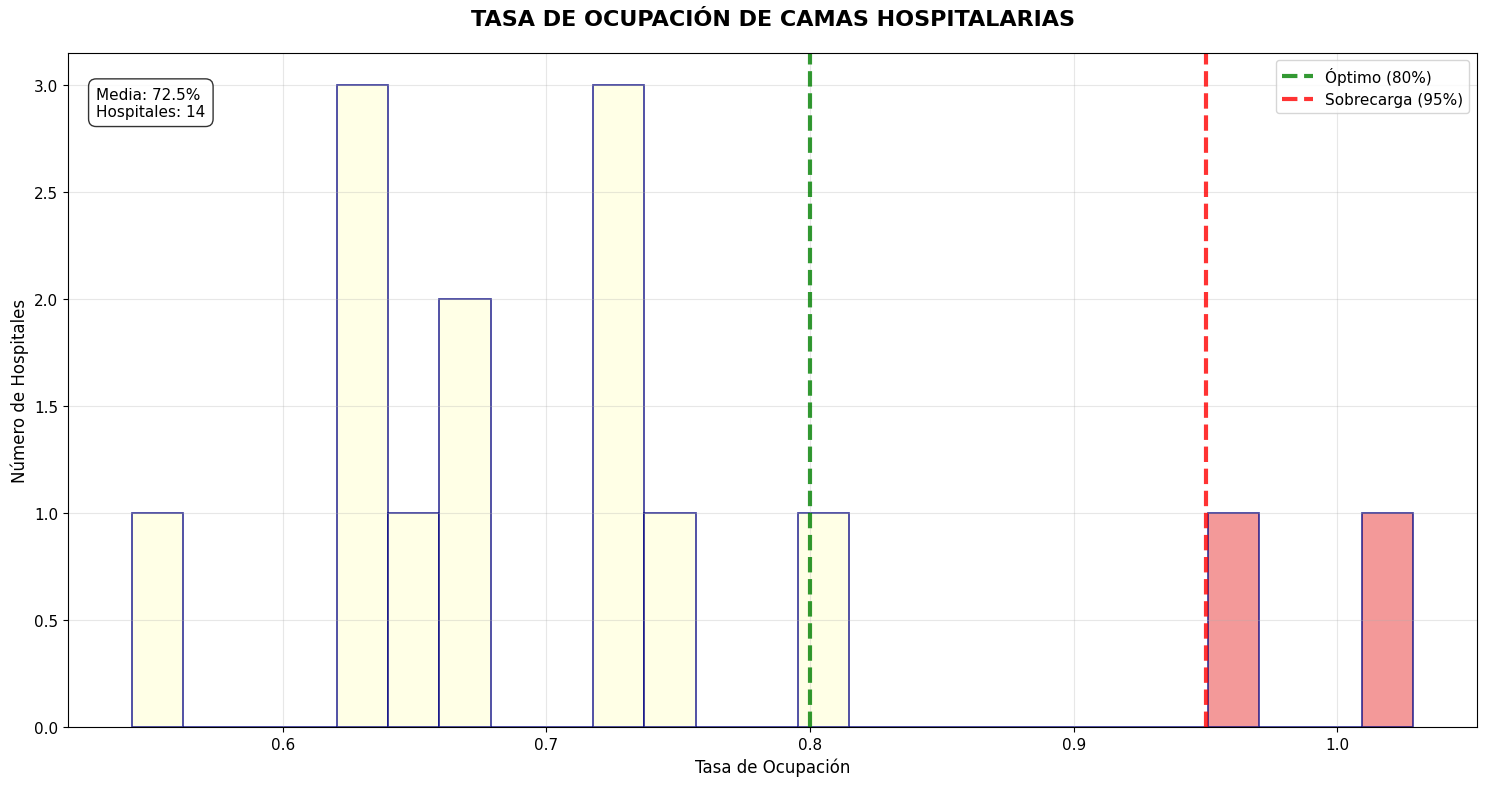


📋 INTERPRETACIÓN: TASA DE OCUPACIÓN DE CAMAS
🏥 DISTRIBUCIÓN DE HOSPITALES:
   • Ocupación ÓPTIMA (80-95%): 1 hospitales (7.1%)
   • Ocupación BAJA (<80%): 11 hospitales (78.6%)
   • Ocupación ALTA (>95%): 2 hospitales (14.3%)

📈 INDICADORES CLAVE:
   • Tasa promedio: 72.5%
   • Rango: 54.3% - 102.9%

💡 CONCLUSIÓN: La mayoría de hospitales tiene subutilización de camas.
   Esto puede indicar baja demanda o exceso de capacidad instalada.


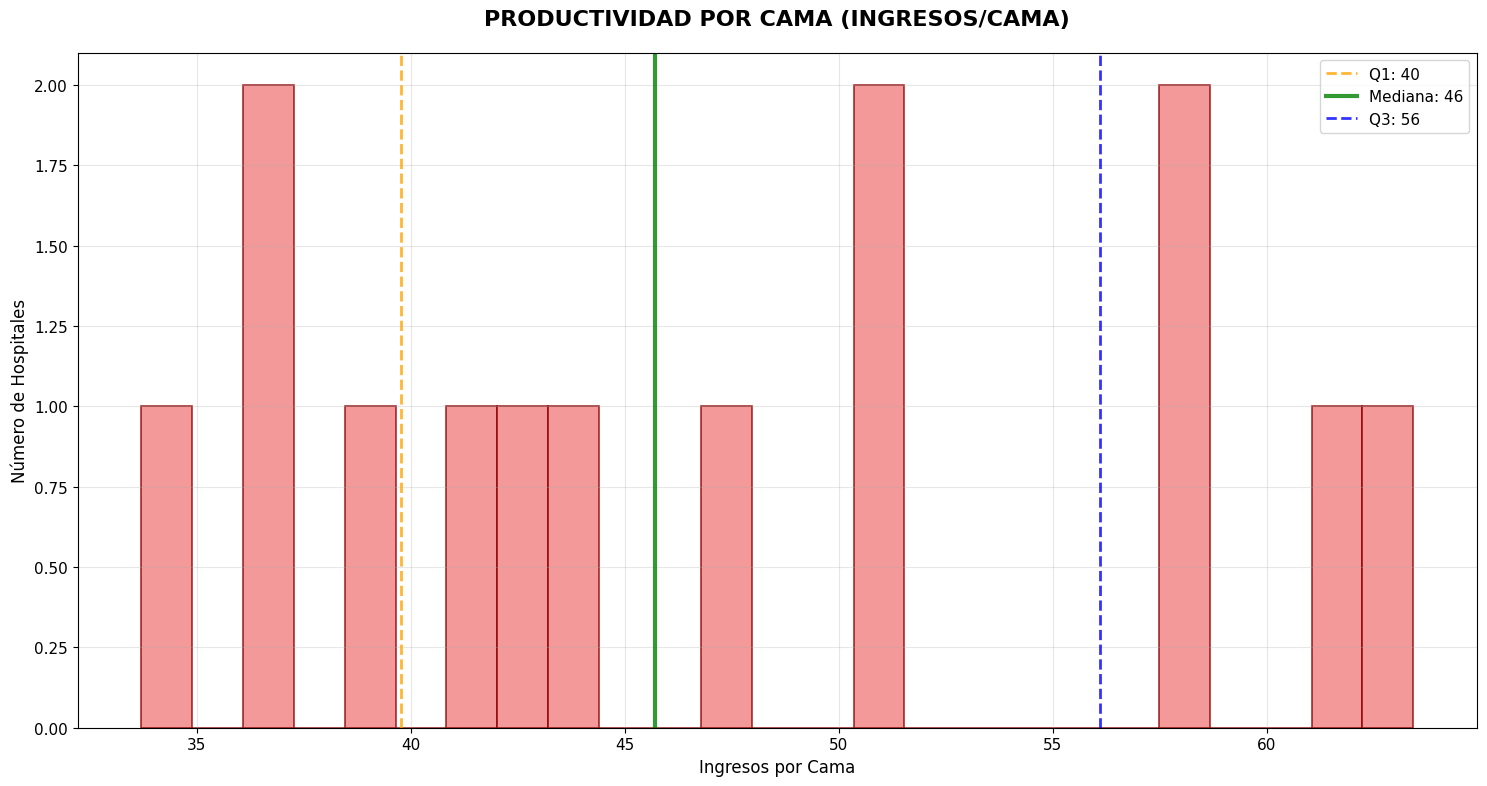


📋 INTERPRETACIÓN: PRODUCTIVIDAD POR CAMA
📊 DISTRIBUCIÓN DE PRODUCTIVIDAD:
   • Alto rendimiento (>Q3): 4 hospitales (28.6%)
   • Rendimiento medio (Q1-Q3): 6 hospitales
   • Bajo rendimiento (<Q1): 4 hospitales (28.6%)

📈 MÉTRICAS CLAVE:
   • Productividad promedio: 47.5 ingresos/cama
   • Mediana: 45.7 ingresos/cama
   • Rango intercuartílico: 40 - 56 ingresos/cama
   • Desviación estándar: 9.9

📊 CONCLUSIÓN: La productividad es relativamente homogénea entre hospitales.
   La mayoría de hospitales tiene niveles similares de utilización de camas.

💡 IMPLICACIONES:
   • Hospitales con baja productividad pueden necesitar optimización de procesos
   • La variabilidad sugiere oportunidades de mejores prácticas entre hospitales


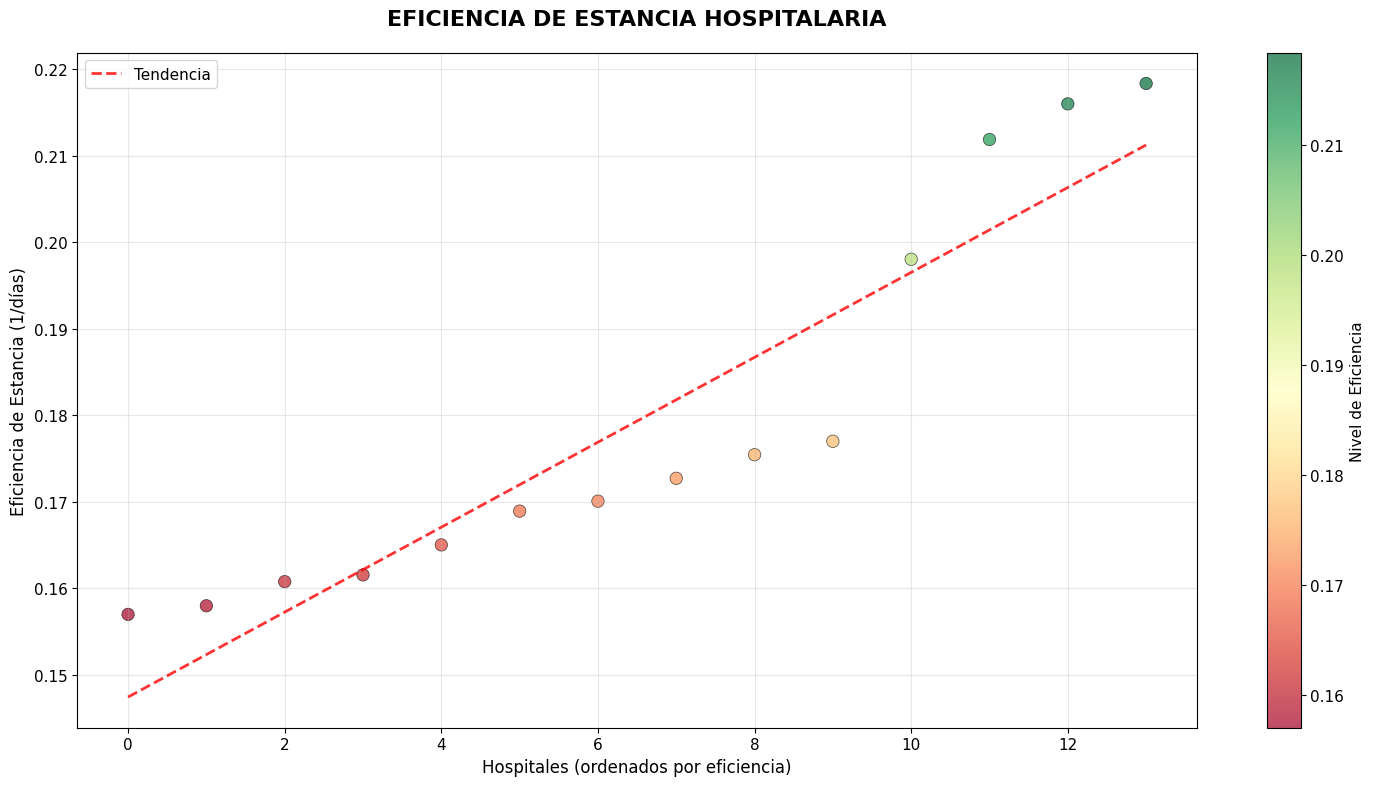


📋 INTERPRETACIÓN: EFICIENCIA DE ESTANCIA
⏱️  ANÁLISIS DE ESTANCIA HOSPITALARIA:
   • Eficiencia promedio: 0.179 (≈ 5.6 días de estancia)
   • Hospital MÁS eficiente: 0.218 (≈ 4.6 días)
   • Hospital MENOS eficiente: 0.157 (≈ 6.4 días)
   • Rango de variación: 1.4x entre el mejor y peor

📊 DISTRIBUCIÓN POR EFICIENCIA:
   • Alta eficiencia (tercil superior): 5 hospitales (35.7%)
   • Eficiencia media: 4 hospitales (28.6%)
   • Baja eficiencia (tercil inferior): 5 hospitales (35.7%)

📊 CONCLUSIÓN: La estancia promedio (5.6 días) está en rango normal.

💡 IMPLICACIONES:
   • Hospitales menos eficientes pueden necesitar optimización de procesos
   • La variabilidad sugiere diferentes complejidades de casos o protocolos


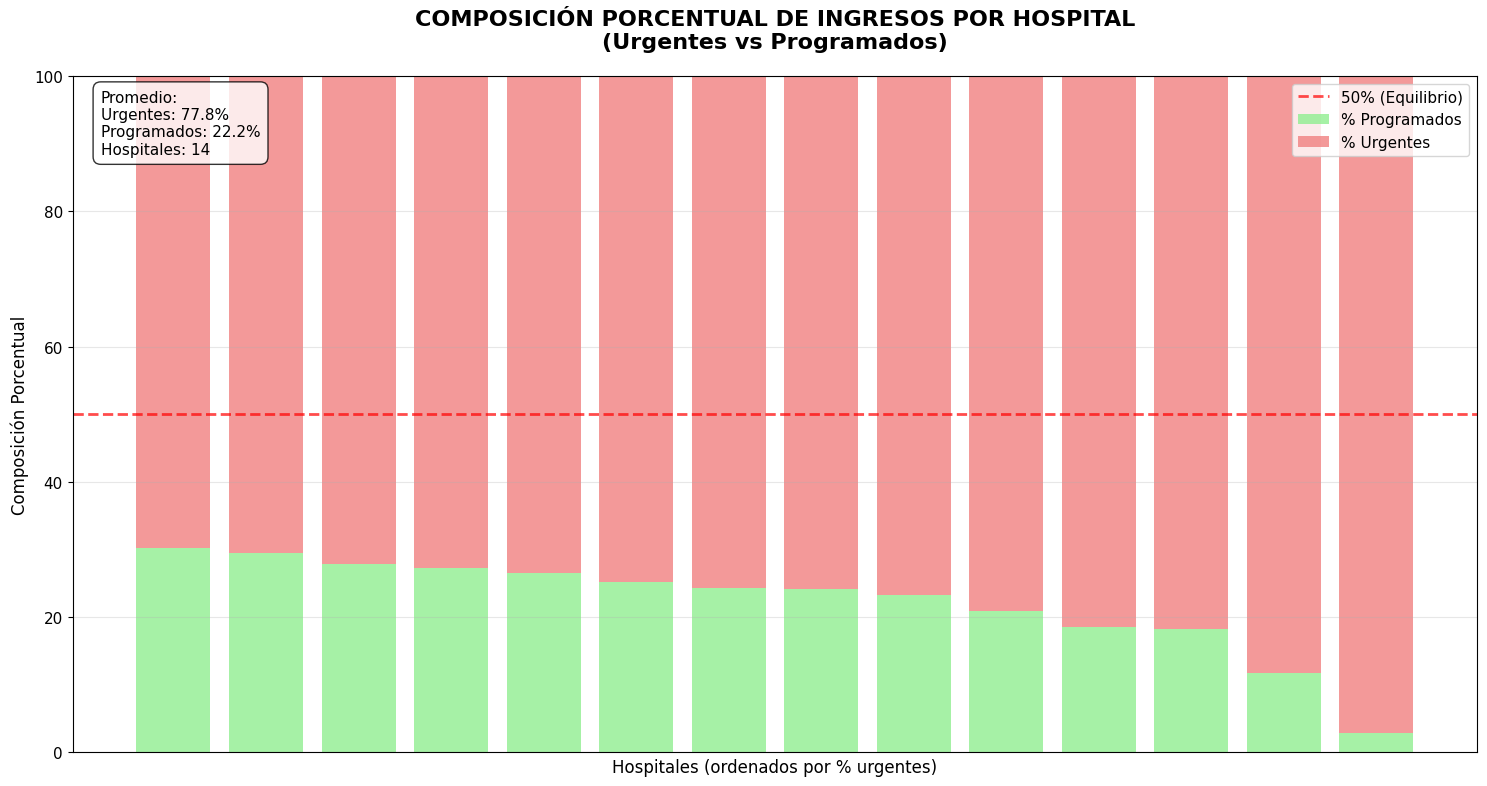


📋 INTERPRETACIÓN: COMPOSICIÓN PORCENTUAL DE INGRESOS
📊 ESTADÍSTICAS GENERALES:
   • Porcentaje promedio urgentes: 77.8%
   • Porcentaje promedio programados: 22.2%
   • Ratio promedio (U/P): 5.70
   • Ratio mediano (U/P): 3.12
   • Hospitales analizados: 14

🏥 DISTRIBUCIÓN POR COMPOSICIÓN:
   • Muy urgentes (>67% urgentes): 14 hospitales (100.0%)
   • Equilibrados (42-57% urgentes): 0 hospitales (0.0%)
   • Muy programados (<33% urgentes): 0 hospitales (0.0%)

⚠️  CONCLUSIÓN: Predominan claramente los ingresos de urgencia (77.8%).
   Esto sugiere un sistema reactivo que necesita fortalecer la atención programada.

💡 INTERPRETACIÓN DE LA GRÁFICA:
   • Cada barra representa un hospital ordenado por % de urgentes (menor a mayor)
   • Verde: Porcentaje de ingresos programados
   • Rojo: Porcentaje de ingresos urgentes
   • Línea roja discontinua: Punto de equilibrio (50%)
   • Hospitales a la izquierda son más programados, a la derecha más urgentes

🎯 RECOMENDACIONES:
   • 14 hospitales c

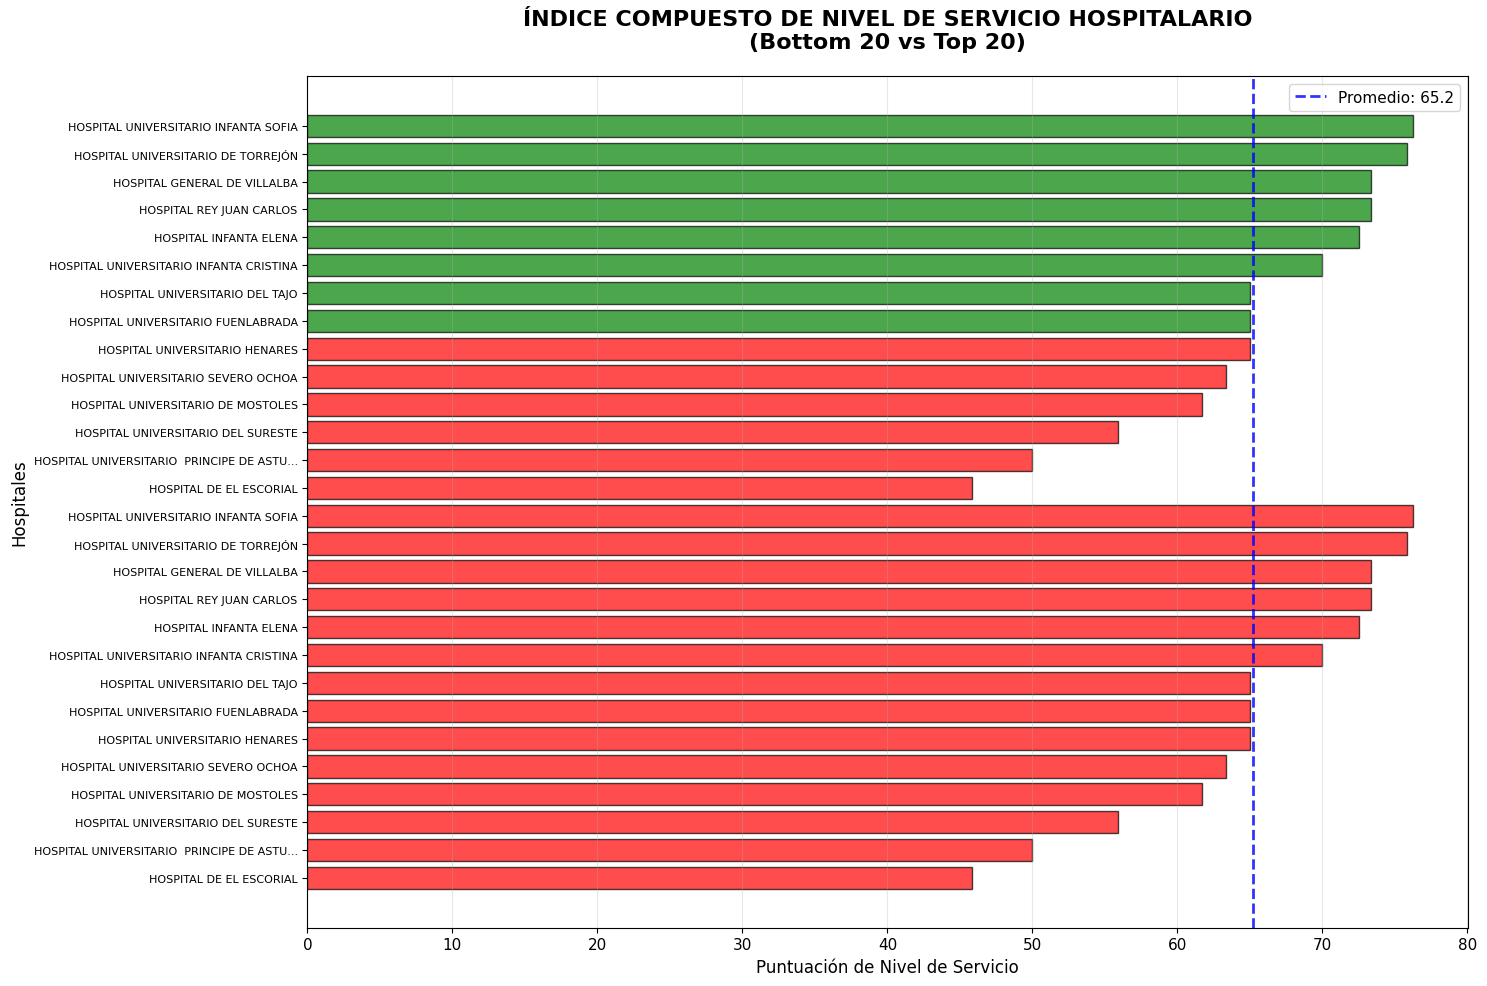


📋 INTERPRETACIÓN: ÍNDICE COMPUESTO DE NIVEL DE SERVICIO
🏆 DISTRIBUCIÓN DE PERFORMANCE:
   • Alto rendimiento (≥75): 2 hospitales (14.3%)
   • Rendimiento medio (50-74): 11 hospitales (78.6%)
   • Bajo rendimiento (<50): 1 hospitales (7.1%)

📊 MÉTRICAS DEL SISTEMA:
   • Puntuación promedio: 65.2/100
   • Mejor hospital: 76.2/100
   • Peor hospital: 45.8/100
   • Brecha de performance: 30.4 puntos
   • Desviación estándar: 9.4

📊 CONCLUSIÓN: Hay disparidad moderada en el nivel de servicio.
   Oportunidad de mejora para hospitales de menor rendimiento.

💡 RECOMENDACIONES:
   • Fortalecer hospitales bottom 20 con recursos y capacitación
   • Establecer benchmarks basados en hospitales top 20


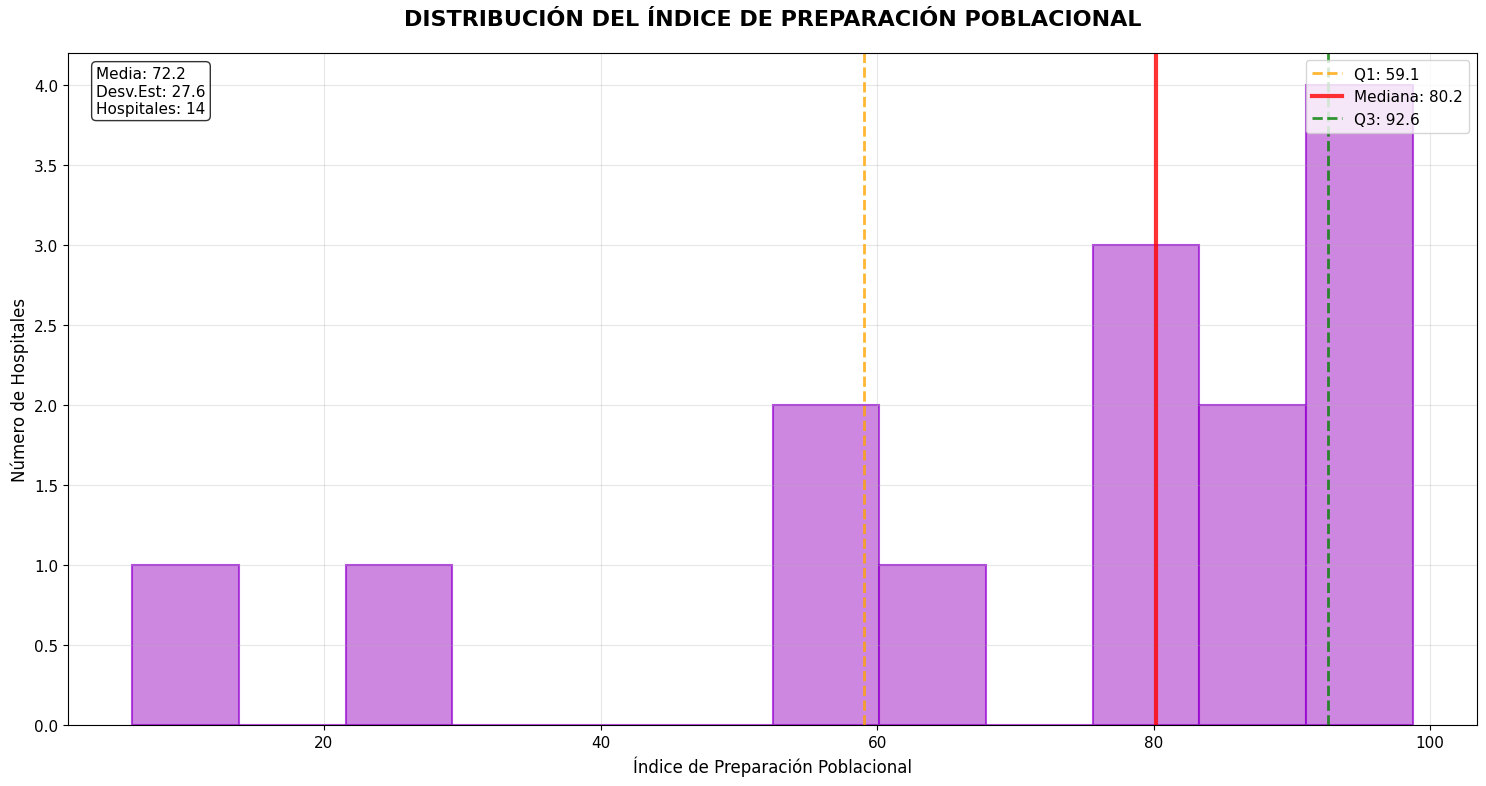

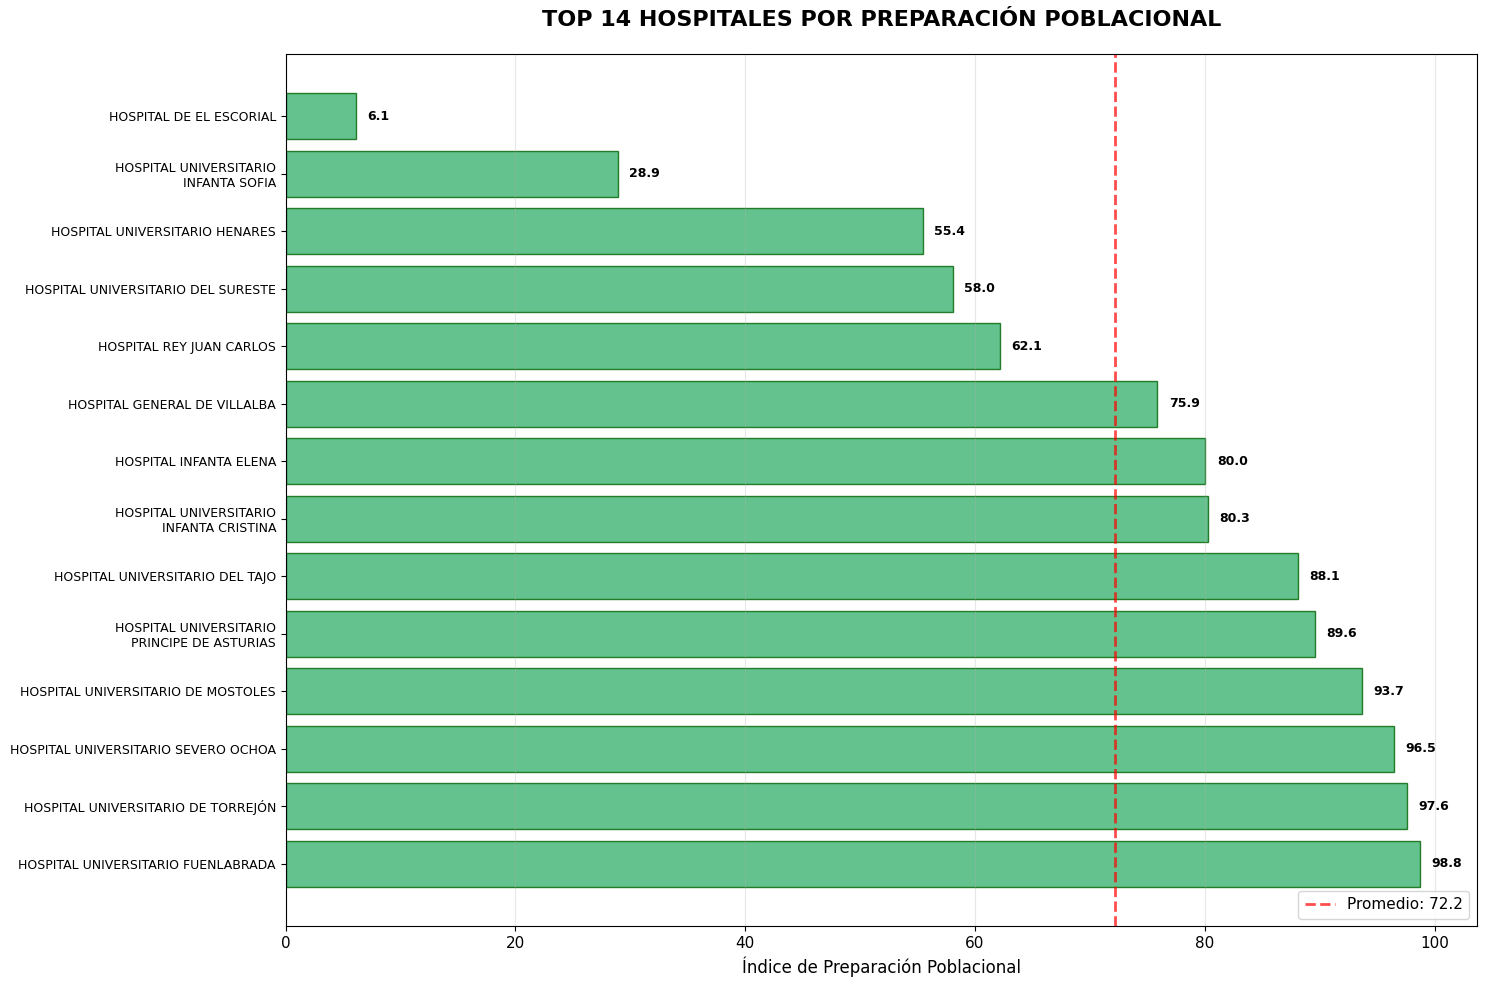


📋 INTERPRETACIÓN: PREPARACIÓN POBLACIONAL
🏥 DISTRIBUCIÓN DE PREPARACIÓN:
   • Alta preparación (≥Q3): 4 hospitales (28.6%)
   • Preparación media (Q1-Q3): 6 hospitales (42.9%)
   • Baja preparación (<Q1): 4 hospitales (28.6%)

📊 MÉTRICAS DE PREPARACIÓN:
   • Índice promedio: 72.2/100
   • Mediana: 80.2/100
   • Rango: 6.1 - 98.8
   • Variabilidad (σ): 27.6

✅ CONCLUSIÓN: El sistema tiene buena preparación poblacional.
   Los hospitales están bien equipados para atender a su población asignada.

💡 ANÁLISIS POR COMPONENTES:
   • Camas por 1000 habitantes: Indica capacidad de hospitalización
   • Atención por 1000 habitantes: Refleja volumen de servicios
   • Urgencias por 1000 habitantes: Muestra capacidad de emergencias

📈 VARIABILIDAD ALTA:
   Existe gran disparidad entre hospitales en preparación poblacional.
   Algunos hospitales están muy por encima/debajo del promedio.

🎯 RECOMENDACIONES:
   • Redistribuir recursos hacia hospitales con baja preparación
   • Analizar carga poblacio

In [14]:
# === GRÁFICAS DE INDICADORES HOSPITALARIOS ===

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficas
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 11

print("\n" + "="*80)
print("📊 ANÁLISIS DE INDICADORES HOSPITALARIOS 2022")
print("="*80)

# === 1. TASA DE OCUPACIÓN DE CAMAS ===
if 'tasa_ocupacion_camas' in hospital_unique_results.columns:
    plt.figure(figsize=(15, 8))

    # Histograma con líneas de referencia
    n, bins, patches = plt.hist(hospital_unique_results['tasa_ocupacion_camas'],
                               bins=25, alpha=0.8, color='skyblue', edgecolor='navy', linewidth=1.2)

    # Líneas de referencia para ocupación óptima
    plt.axvline(x=0.8, color='green', linestyle='--', linewidth=3, label='Óptimo (80%)', alpha=0.8)
    plt.axvline(x=0.95, color='red', linestyle='--', linewidth=3, label='Sobrecarga (95%)', alpha=0.8)

    # Colorear barras según rangos
    for i, patch in enumerate(patches):
        if bins[i] >= 0.8 and bins[i] <= 0.95:
            patch.set_facecolor('lightgreen')
        elif bins[i] > 0.95:
            patch.set_facecolor('lightcoral')
        else:
            patch.set_facecolor('lightyellow')

    plt.title('TASA DE OCUPACIÓN DE CAMAS HOSPITALARIAS', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Tasa de Ocupación', fontsize=12)
    plt.ylabel('Número de Hospitales', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Estadísticas en el gráfico
    mean_val = hospital_unique_results['tasa_ocupacion_camas'].mean()
    plt.text(0.02, 0.95, f'Media: {mean_val:.1%}\nHospitales: {len(hospital_unique_results)}',
             transform=plt.gca().transAxes, fontsize=11,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
             verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # Interpretación de la gráfica
    print("\n" + "="*60)
    print("📋 INTERPRETACIÓN: TASA DE OCUPACIÓN DE CAMAS")
    print("="*60)

    # Calcular estadísticas para interpretación
    ocupacion_optima = len(hospital_unique_results[(hospital_unique_results['tasa_ocupacion_camas'] >= 0.8) &
                                                   (hospital_unique_results['tasa_ocupacion_camas'] <= 0.95)])
    ocupacion_baja = len(hospital_unique_results[hospital_unique_results['tasa_ocupacion_camas'] < 0.8])
    ocupacion_alta = len(hospital_unique_results[hospital_unique_results['tasa_ocupacion_camas'] > 0.95])

    print(f"🏥 DISTRIBUCIÓN DE HOSPITALES:")
    print(f"   • Ocupación ÓPTIMA (80-95%): {ocupacion_optima} hospitales ({ocupacion_optima/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Ocupación BAJA (<80%): {ocupacion_baja} hospitales ({ocupacion_baja/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Ocupación ALTA (>95%): {ocupacion_alta} hospitales ({ocupacion_alta/len(hospital_unique_results)*100:.1f}%)")
    print(f"\n📈 INDICADORES CLAVE:")
    print(f"   • Tasa promedio: {mean_val:.1%}")
    print(f"   • Rango: {hospital_unique_results['tasa_ocupacion_camas'].min():.1%} - {hospital_unique_results['tasa_ocupacion_camas'].max():.1%}")

    if ocupacion_baja > ocupacion_alta:
        print(f"\n💡 CONCLUSIÓN: La mayoría de hospitales tiene subutilización de camas.")
        print(f"   Esto puede indicar baja demanda o exceso de capacidad instalada.")
    elif ocupacion_alta > ocupacion_optima:
        print(f"\n⚠️  CONCLUSIÓN: Muchos hospitales operan con sobrecarga.")
        print(f"   Esto puede comprometer la calidad de atención y generar saturación.")
    else:
        print(f"\n✅ CONCLUSIÓN: La mayoría de hospitales opera en rangos óptimos.")
        print(f"   Esto indica un balance adecuado entre capacidad y demanda.")
    print("="*60)

# === 2. PRODUCTIVIDAD POR CAMA ===
if 'productividad_camas' in hospital_unique_results.columns:
    plt.figure(figsize=(15, 8))

    # Histograma mejorado
    n, bins, patches = plt.hist(hospital_unique_results['productividad_camas'],
                               bins=25, alpha=0.8, color='lightcoral', edgecolor='darkred', linewidth=1.2)

    # Líneas de percentiles
    q25 = hospital_unique_results['productividad_camas'].quantile(0.25)
    q50 = hospital_unique_results['productividad_camas'].median()
    q75 = hospital_unique_results['productividad_camas'].quantile(0.75)

    plt.axvline(x=q25, color='orange', linestyle='--', linewidth=2, label=f'Q1: {q25:.0f}', alpha=0.8)
    plt.axvline(x=q50, color='green', linestyle='-', linewidth=3, label=f'Mediana: {q50:.0f}', alpha=0.8)
    plt.axvline(x=q75, color='blue', linestyle='--', linewidth=2, label=f'Q3: {q75:.0f}', alpha=0.8)

    plt.title('PRODUCTIVIDAD POR CAMA (INGRESOS/CAMA)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Ingresos por Cama', fontsize=12)
    plt.ylabel('Número de Hospitales', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Interpretación de la gráfica
    print("\n" + "="*60)
    print("📋 INTERPRETACIÓN: PRODUCTIVIDAD POR CAMA")
    print("="*60)

    # Calcular estadísticas para interpretación
    prod_media = hospital_unique_results['productividad_camas'].mean()
    prod_std = hospital_unique_results['productividad_camas'].std()
    hospitales_alto_rendimiento = len(hospital_unique_results[hospital_unique_results['productividad_camas'] > q75])
    hospitales_bajo_rendimiento = len(hospital_unique_results[hospital_unique_results['productividad_camas'] < q25])

    print(f"📊 DISTRIBUCIÓN DE PRODUCTIVIDAD:")
    print(f"   • Alto rendimiento (>Q3): {hospitales_alto_rendimiento} hospitales ({hospitales_alto_rendimiento/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Rendimiento medio (Q1-Q3): {len(hospital_unique_results) - hospitales_alto_rendimiento - hospitales_bajo_rendimiento} hospitales")
    print(f"   • Bajo rendimiento (<Q1): {hospitales_bajo_rendimiento} hospitales ({hospitales_bajo_rendimiento/len(hospital_unique_results)*100:.1f}%)")

    print(f"\n📈 MÉTRICAS CLAVE:")
    print(f"   • Productividad promedio: {prod_media:.1f} ingresos/cama")
    print(f"   • Mediana: {q50:.1f} ingresos/cama")
    print(f"   • Rango intercuartílico: {q25:.0f} - {q75:.0f} ingresos/cama")
    print(f"   • Desviación estándar: {prod_std:.1f}")

    if prod_std > prod_media * 0.5:
        print(f"\n📉 CONCLUSIÓN: Existe gran variabilidad en la productividad entre hospitales.")
        print(f"   Algunos hospitales son mucho más eficientes que otros en el uso de camas.")
    else:
        print(f"\n📊 CONCLUSIÓN: La productividad es relativamente homogénea entre hospitales.")
        print(f"   La mayoría de hospitales tiene niveles similares de utilización de camas.")

    print(f"\n💡 IMPLICACIONES:")
    print(f"   • Hospitales con baja productividad pueden necesitar optimización de procesos")
    print(f"   • La variabilidad sugiere oportunidades de mejores prácticas entre hospitales")
    print("="*60)

# === 3. EFICIENCIA DE ESTANCIA ===
if 'eficiencia_estancia' in hospital_unique_results.columns:
    plt.figure(figsize=(15, 8))

    # Crear categorías de eficiencia
    df_sorted = hospital_unique_results.sort_values('eficiencia_estancia', ascending=True)

    # Scatter plot con colores por eficiencia
    scatter = plt.scatter(range(len(df_sorted)), df_sorted['eficiencia_estancia'],
                         c=df_sorted['eficiencia_estancia'], cmap='RdYlGn',
                         alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

    plt.title('EFICIENCIA DE ESTANCIA HOSPITALARIA', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Hospitales (ordenados por eficiencia)', fontsize=12)
    plt.ylabel('Eficiencia de Estancia (1/días)', fontsize=12)
    plt.colorbar(scatter, label='Nivel de Eficiencia')
    plt.grid(True, alpha=0.3)

    # Línea de tendencia
    z = np.polyfit(range(len(df_sorted)), df_sorted['eficiencia_estancia'], 1)
    p = np.poly1d(z)
    plt.plot(range(len(df_sorted)), p(range(len(df_sorted))),
             "r--", alpha=0.8, linewidth=2, label='Tendencia')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Interpretación de la gráfica
    print("\n" + "="*60)
    print("📋 INTERPRETACIÓN: EFICIENCIA DE ESTANCIA")
    print("="*60)

    # Calcular estadísticas para interpretación
    ef_media = hospital_unique_results['eficiencia_estancia'].mean()
    ef_mediana = hospital_unique_results['eficiencia_estancia'].median()
    ef_min = hospital_unique_results['eficiencia_estancia'].min()
    ef_max = hospital_unique_results['eficiencia_estancia'].max()

    # Convertir a días promedio de estancia
    dias_promedio = 1/ef_media if ef_media > 0 else 0
    dias_mejor = 1/ef_max if ef_max > 0 else 0
    dias_peor = 1/ef_min if ef_min > 0 else 0

    print(f"⏱️  ANÁLISIS DE ESTANCIA HOSPITALARIA:")
    print(f"   • Eficiencia promedio: {ef_media:.3f} (≈ {dias_promedio:.1f} días de estancia)")
    print(f"   • Hospital MÁS eficiente: {ef_max:.3f} (≈ {dias_mejor:.1f} días)")
    print(f"   • Hospital MENOS eficiente: {ef_min:.3f} (≈ {dias_peor:.1f} días)")
    print(f"   • Rango de variación: {ef_max/ef_min:.1f}x entre el mejor y peor")

    # Clasificar hospitales por eficiencia
    q33_ef = hospital_unique_results['eficiencia_estancia'].quantile(0.33)
    q66_ef = hospital_unique_results['eficiencia_estancia'].quantile(0.66)

    alta_ef = len(hospital_unique_results[hospital_unique_results['eficiencia_estancia'] >= q66_ef])
    media_ef = len(hospital_unique_results[(hospital_unique_results['eficiencia_estancia'] >= q33_ef) &
                                          (hospital_unique_results['eficiencia_estancia'] < q66_ef)])
    baja_ef = len(hospital_unique_results[hospital_unique_results['eficiencia_estancia'] < q33_ef])

    print(f"\n📊 DISTRIBUCIÓN POR EFICIENCIA:")
    print(f"   • Alta eficiencia (tercil superior): {alta_ef} hospitales ({alta_ef/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Eficiencia media: {media_ef} hospitales ({media_ef/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Baja eficiencia (tercil inferior): {baja_ef} hospitales ({baja_ef/len(hospital_unique_results)*100:.1f}%)")

    if dias_promedio > 7:
        print(f"\n⚠️  CONCLUSIÓN: La estancia promedio ({dias_promedio:.1f} días) es relativamente alta.")
        print(f"   Esto puede indicar procesos lentos o casos complejos.")
    elif dias_promedio < 4:
        print(f"\n✅ CONCLUSIÓN: La estancia promedio ({dias_promedio:.1f} días) es eficiente.")
        print(f"   Los hospitales procesan pacientes con rapidez adecuada.")
    else:
        print(f"\n📊 CONCLUSIÓN: La estancia promedio ({dias_promedio:.1f} días) está en rango normal.")

    print(f"\n💡 IMPLICACIONES:")
    print(f"   • Hospitales menos eficientes pueden necesitar optimización de procesos")
    print(f"   • La variabilidad sugiere diferentes complejidades de casos o protocolos")
    print("="*60)

# === 4. PROPORCIÓN INGRESOS URGENTES VS PROGRAMADOS ===
if 'ratio_urgentes_programados' in hospital_unique_results.columns:

    # Filtrar datos válidos
    valid_data = hospital_unique_results[
        (hospital_unique_results['ingresos_urgentes'] > 0) &
        (hospital_unique_results['ingresos_programados'] > 0)
    ].copy()

    if len(valid_data) > 0:
        plt.figure(figsize=(15, 8))

        # Calcular porcentajes
        valid_data['total_ingresos_calc'] = valid_data['ingresos_urgentes'] + valid_data['ingresos_programados']
        valid_data['pct_urgentes'] = (valid_data['ingresos_urgentes'] / valid_data['total_ingresos_calc']) * 100
        valid_data['pct_programados'] = (valid_data['ingresos_programados'] / valid_data['total_ingresos_calc']) * 100

        # Ordenar por porcentaje de urgentes
        valid_data_sorted = valid_data.sort_values('pct_urgentes', ascending=True)

        # Crear gráfico de barras apiladas (muestra solo una muestra si hay muchos hospitales)
        if len(valid_data_sorted) > 50:
            # Mostrar cada N hospitales para no saturar la visualización
            sample_data = valid_data_sorted.iloc[::max(1, len(valid_data_sorted)//40)]
        else:
            sample_data = valid_data_sorted

        x_pos = range(len(sample_data))

        # Crear barras apiladas
        bars1 = plt.bar(x_pos, sample_data['pct_programados'],
                       color='lightgreen', alpha=0.8, label='% Programados', width=0.8)
        bars2 = plt.bar(x_pos, sample_data['pct_urgentes'],
                       bottom=sample_data['pct_programados'],
                       color='lightcoral', alpha=0.8, label='% Urgentes', width=0.8)

        # Línea de referencia al 50%
        plt.axhline(y=50, color='red', linestyle='--', alpha=0.7, linewidth=2, label='50% (Equilibrio)')

        plt.xlabel('Hospitales (ordenados por % urgentes)', fontsize=12)
        plt.ylabel('Composición Porcentual', fontsize=12)
        plt.title('COMPOSICIÓN PORCENTUAL DE INGRESOS POR HOSPITAL\n(Urgentes vs Programados)',
                  fontsize=16, fontweight='bold', pad=20)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3, axis='y')
        plt.ylim(0, 100)

        # Quitar etiquetas X para mayor claridad
        plt.xticks([])

        # Agregar estadísticas en el gráfico
        pct_urgentes_promedio = valid_data['pct_urgentes'].mean()
        pct_programados_promedio = valid_data['pct_programados'].mean()

        stats_text = f'Promedio:\nUrgentes: {pct_urgentes_promedio:.1f}%\nProgramados: {pct_programados_promedio:.1f}%\nHospitales: {len(valid_data)}'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.8),
                verticalalignment='top')

        plt.tight_layout()
        plt.show()

        # Interpretación de la gráfica
        print("\n" + "="*60)
        print("📋 INTERPRETACIÓN: COMPOSICIÓN PORCENTUAL DE INGRESOS")
        print("="*60)

        # Calcular estadísticas para interpretación
        ratio_data = hospital_unique_results['ratio_urgentes_programados'].dropna()
        ratio_data = ratio_data[np.isfinite(ratio_data)]

        if len(ratio_data) > 0:
            ratio_medio = ratio_data.mean()
            ratio_mediana = ratio_data.median()

            print(f"📊 ESTADÍSTICAS GENERALES:")
            print(f"   • Porcentaje promedio urgentes: {pct_urgentes_promedio:.1f}%")
            print(f"   • Porcentaje promedio programados: {pct_programados_promedio:.1f}%")
            print(f"   • Ratio promedio (U/P): {ratio_medio:.2f}")
            print(f"   • Ratio mediano (U/P): {ratio_mediana:.2f}")
            print(f"   • Hospitales analizados: {len(valid_data)}")

            # Clasificar hospitales por composición
            muy_urgentes = len(valid_data[valid_data['pct_urgentes'] > 67])
            equilibrados = len(valid_data[(valid_data['pct_urgentes'] >= 42) & (valid_data['pct_urgentes'] <= 57)])
            muy_programados = len(valid_data[valid_data['pct_urgentes'] < 33])

            print(f"\n🏥 DISTRIBUCIÓN POR COMPOSICIÓN:")
            print(f"   • Muy urgentes (>67% urgentes): {muy_urgentes} hospitales ({muy_urgentes/len(valid_data)*100:.1f}%)")
            print(f"   • Equilibrados (42-57% urgentes): {equilibrados} hospitales ({equilibrados/len(valid_data)*100:.1f}%)")
            print(f"   • Muy programados (<33% urgentes): {muy_programados} hospitales ({muy_programados/len(valid_data)*100:.1f}%)")

            # Conclusiones contextualizadas
            if pct_urgentes_promedio > 60:
                print(f"\n⚠️  CONCLUSIÓN: Predominan claramente los ingresos de urgencia ({pct_urgentes_promedio:.1f}%).")
                print(f"   Esto sugiere un sistema reactivo que necesita fortalecer la atención programada.")
            elif pct_urgentes_promedio < 40:
                print(f"\n✅ CONCLUSIÓN: Predominan los ingresos programados ({pct_programados_promedio:.1f}%).")
                print(f"   Esto indica un buen sistema de planificación y medicina preventiva.")
            else:
                print(f"\n📊 CONCLUSIÓN: Sistema relativamente equilibrado.")
                print(f"   Balance apropiado entre atención reactiva y preventiva.")

            print(f"\n💡 INTERPRETACIÓN DE LA GRÁFICA:")
            print(f"   • Cada barra representa un hospital ordenado por % de urgentes (menor a mayor)")
            print(f"   • Verde: Porcentaje de ingresos programados")
            print(f"   • Rojo: Porcentaje de ingresos urgentes")
            print(f"   • Línea roja discontinua: Punto de equilibrio (50%)")
            print(f"   • Hospitales a la izquierda son más programados, a la derecha más urgentes")

            print(f"\n🎯 RECOMENDACIONES:")
            if muy_urgentes > len(valid_data) * 0.2:
                print(f"   • {muy_urgentes} hospitales con >67% urgentes necesitan fortalecer atención programada")
            if equilibrados > len(valid_data) * 0.3:
                print(f"   • {equilibrados} hospitales equilibrados pueden servir como modelo")
            print(f"   • Analizar diferencias operativas entre hospitales extremos")
            print(f"   • Considerar características poblacionales y geográficas específicas")

        else:
            print(f"⚠️  No hay datos suficientes para análisis completo")

    else:
        print(f"⚠️  No hay datos válidos de ingresos urgentes y programados para el análisis")

    print("="*60)

# === 5. ÍNDICE COMPUESTO DE NIVEL DE SERVICIO ===
if 'nivel_servicio_score' in hospital_unique_results.columns:
    plt.figure(figsize=(15, 10))

    # Ordenar hospitales por nivel de servicio
    df_sorted = hospital_unique_results.sort_values('nivel_servicio_score', ascending=True)

    # Seleccionar top 20 y bottom 20 para visualización
    top_20 = df_sorted.tail(20)
    bottom_20 = df_sorted.head(20)
    combined = pd.concat([bottom_20, top_20])

    # Crear colores: rojo para bottom, verde para top
    colors = ['red'] * 20 + ['green'] * 20

    y_pos = range(len(combined))
    bars = plt.barh(y_pos, combined['nivel_servicio_score'], color=colors, alpha=0.7, edgecolor='black')

    plt.title('ÍNDICE COMPUESTO DE NIVEL DE SERVICIO HOSPITALARIO\n(Bottom 20 vs Top 20)',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Puntuación de Nivel de Servicio', fontsize=12)
    plt.ylabel('Hospitales', fontsize=12)

    # Etiquetas en el eje Y (nombres abreviados)
    labels = [name[:40] + '...' if len(name) > 40 else name for name in combined['hospital_name']]
    plt.yticks(y_pos, labels, fontsize=8)
    plt.grid(True, alpha=0.3, axis='x')

    # Línea de promedio
    mean_score = hospital_unique_results['nivel_servicio_score'].mean()
    plt.axvline(x=mean_score, color='blue', linestyle='--', linewidth=2, alpha=0.8, label=f'Promedio: {mean_score:.1f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Interpretación de la gráfica
    print("\n" + "="*60)
    print("📋 INTERPRETACIÓN: ÍNDICE COMPUESTO DE NIVEL DE SERVICIO")
    print("="*60)

    # Calcular estadísticas para interpretación
    score_std = hospital_unique_results['nivel_servicio_score'].std()
    score_min = hospital_unique_results['nivel_servicio_score'].min()
    score_max = hospital_unique_results['nivel_servicio_score'].max()
    brecha = score_max - score_min

    # Clasificar hospitales por performance
    alto_rendimiento = len(hospital_unique_results[hospital_unique_results['nivel_servicio_score'] >= 75])
    medio_rendimiento = len(hospital_unique_results[(hospital_unique_results['nivel_servicio_score'] >= 50) &
                                                   (hospital_unique_results['nivel_servicio_score'] < 75)])
    bajo_rendimiento = len(hospital_unique_results[hospital_unique_results['nivel_servicio_score'] < 50])

    print(f"🏆 DISTRIBUCIÓN DE PERFORMANCE:")
    print(f"   • Alto rendimiento (≥75): {alto_rendimiento} hospitales ({alto_rendimiento/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Rendimiento medio (50-74): {medio_rendimiento} hospitales ({medio_rendimiento/len(hospital_unique_results)*100:.1f}%)")
    print(f"   • Bajo rendimiento (<50): {bajo_rendimiento} hospitales ({bajo_rendimiento/len(hospital_unique_results)*100:.1f}%)")

    print(f"\n📊 MÉTRICAS DEL SISTEMA:")
    print(f"   • Puntuación promedio: {mean_score:.1f}/100")
    print(f"   • Mejor hospital: {score_max:.1f}/100")
    print(f"   • Peor hospital: {score_min:.1f}/100")
    print(f"   • Brecha de performance: {brecha:.1f} puntos")
    print(f"   • Desviación estándar: {score_std:.1f}")

    if brecha > 40:
        print(f"\n⚠️  CONCLUSIÓN: Existe gran disparidad en el nivel de servicio.")
        print(f"   La brecha de {brecha:.1f} puntos indica inequidad significativa.")
    elif brecha > 25:
        print(f"\n📊 CONCLUSIÓN: Hay disparidad moderada en el nivel de servicio.")
        print(f"   Oportunidad de mejora para hospitales de menor rendimiento.")
    else:
        print(f"\n✅ CONCLUSIÓN: El nivel de servicio es relativamente homogéneo.")
        print(f"   La mayoría de hospitales mantiene estándares similares.")

    print(f"\n💡 RECOMENDACIONES:")
    if bajo_rendimiento > len(hospital_unique_results) * 0.25:
        print(f"   • Implementar programas de mejora para hospitales de bajo rendimiento")
        print(f"   • Transferir mejores prácticas desde hospitales top")
    print(f"   • Fortalecer hospitales bottom 20 con recursos y capacitación")
    print(f"   • Establecer benchmarks basados en hospitales top 20")
    print("="*60)

# === 6. PREPARACIÓN POBLACIONAL ===
if 'indice_preparacion_poblacional' in hospital_unique_results.columns:
    # Verificar que hay datos válidos
    valid_prep_data = hospital_unique_results['indice_preparacion_poblacional'].dropna()
    valid_prep_data = valid_prep_data[np.isfinite(valid_prep_data)]

    if len(valid_prep_data) > 0:
        # === GRÁFICA 6A: DISTRIBUCIÓN DE PREPARACIÓN POBLACIONAL ===
        plt.figure(figsize=(15, 8))

        # Crear histograma básico
        counts, bins, patches = plt.hist(valid_prep_data, bins=12, alpha=0.7,
                                        color='mediumorchid', edgecolor='darkviolet', linewidth=1.5)

        # Agregar líneas de percentiles
        p25 = valid_prep_data.quantile(0.25)
        p50 = valid_prep_data.quantile(0.50)
        p75 = valid_prep_data.quantile(0.75)

        plt.axvline(p25, color='orange', linestyle='--', linewidth=2, alpha=0.8, label=f'Q1: {p25:.1f}')
        plt.axvline(p50, color='red', linestyle='-', linewidth=3, alpha=0.8, label=f'Mediana: {p50:.1f}')
        plt.axvline(p75, color='green', linestyle='--', linewidth=2, alpha=0.8, label=f'Q3: {p75:.1f}')

        plt.title('DISTRIBUCIÓN DEL ÍNDICE DE PREPARACIÓN POBLACIONAL',
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Índice de Preparación Poblacional', fontsize=12)
        plt.ylabel('Número de Hospitales', fontsize=12)
        plt.legend(loc='upper right', fontsize=11)
        plt.grid(True, alpha=0.3)

        # Agregar texto con estadísticas
        stats_text = f'Media: {valid_prep_data.mean():.1f}\nDesv.Est: {valid_prep_data.std():.1f}\nHospitales: {len(valid_prep_data)}'
        plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8),
                verticalalignment='top')

        plt.tight_layout()
        plt.show()

        # === GRÁFICA 6B: TOP HOSPITALES POR PREPARACIÓN ===
        plt.figure(figsize=(15, 10))

        # Obtener top 15 hospitales por preparación poblacional
        hospital_data = hospital_unique_results.dropna(subset=['indice_preparacion_poblacional', 'hospital_name'])
        hospital_data = hospital_data[np.isfinite(hospital_data['indice_preparacion_poblacional'])]

        if len(hospital_data) >= 10:
            top_hospitals = hospital_data.nlargest(15, 'indice_preparacion_poblacional')

            # Crear gráfico de barras horizontal
            y_positions = range(len(top_hospitals))
            bars = plt.barh(y_positions, top_hospitals['indice_preparacion_poblacional'],
                           color='mediumseagreen', alpha=0.8, edgecolor='darkgreen', linewidth=1)

            # Configurar etiquetas
            hospital_labels = []
            for name in top_hospitals['hospital_name']:
                if len(name) > 35:
                    # Dividir nombre largo
                    words = name.split()
                    mid = len(words) // 2
                    line1 = ' '.join(words[:mid])
                    line2 = ' '.join(words[mid:])
                    label = f'{line1[:25]}...\n{line2[:25]}...' if len(line1) > 25 else f'{line1}\n{line2}'
                else:
                    label = name
                hospital_labels.append(label)

            plt.yticks(y_positions, hospital_labels, fontsize=9)

            # Agregar valores al final de cada barra
            for i, (pos, val) in enumerate(zip(y_positions, top_hospitals['indice_preparacion_poblacional'])):
                plt.text(val + 1, pos, f'{val:.1f}', va='center', fontsize=9, fontweight='bold')

            plt.title(f'TOP {len(top_hospitals)} HOSPITALES POR PREPARACIÓN POBLACIONAL',
                     fontsize=16, fontweight='bold', pad=20)
            plt.xlabel('Índice de Preparación Poblacional', fontsize=12)
            plt.grid(True, alpha=0.3, axis='x')

            # Agregar línea de promedio
            mean_val = valid_prep_data.mean()
            plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, alpha=0.7,
                       label=f'Promedio: {mean_val:.1f}')
            plt.legend(loc='lower right', fontsize=11)

            plt.tight_layout()
            plt.show()

        # Interpretación de las gráficas
        print("\n" + "="*60)
        print("📋 INTERPRETACIÓN: PREPARACIÓN POBLACIONAL")
        print("="*60)

        # Calcular estadísticas para interpretación
        prep_media = valid_prep_data.mean()
        prep_std = valid_prep_data.std()
        prep_min = valid_prep_data.min()
        prep_max = valid_prep_data.max()

        # Clasificar hospitales por preparación
        alta_prep = len(valid_prep_data[valid_prep_data >= p75])
        media_prep = len(valid_prep_data[(valid_prep_data >= p25) & (valid_prep_data < p75)])
        baja_prep = len(valid_prep_data[valid_prep_data < p25])

        print(f"🏥 DISTRIBUCIÓN DE PREPARACIÓN:")
        print(f"   • Alta preparación (≥Q3): {alta_prep} hospitales ({alta_prep/len(valid_prep_data)*100:.1f}%)")
        print(f"   • Preparación media (Q1-Q3): {media_prep} hospitales ({media_prep/len(valid_prep_data)*100:.1f}%)")
        print(f"   • Baja preparación (<Q1): {baja_prep} hospitales ({baja_prep/len(valid_prep_data)*100:.1f}%)")

        print(f"\n📊 MÉTRICAS DE PREPARACIÓN:")
        print(f"   • Índice promedio: {prep_media:.1f}/100")
        print(f"   • Mediana: {p50:.1f}/100")
        print(f"   • Rango: {prep_min:.1f} - {prep_max:.1f}")
        print(f"   • Variabilidad (σ): {prep_std:.1f}")

        # Análisis de cobertura poblacional
        cobertura = (prep_media / 100) * len(valid_prep_data)

        if prep_media >= 70:
            print(f"\n✅ CONCLUSIÓN: El sistema tiene buena preparación poblacional.")
            print(f"   Los hospitales están bien equipados para atender a su población asignada.")
        elif prep_media >= 50:
            print(f"\n📊 CONCLUSIÓN: La preparación poblacional es moderada.")
            print(f"   Hay oportunidades de mejora en recursos por habitante.")
        else:
            print(f"\n⚠️  CONCLUSIÓN: La preparación poblacional es insuficiente.")
            print(f"   Los hospitales pueden estar sobrecargados respecto a su población.")

        print(f"\n💡 ANÁLISIS POR COMPONENTES:")
        print(f"   • Camas por 1000 habitantes: Indica capacidad de hospitalización")
        print(f"   • Atención por 1000 habitantes: Refleja volumen de servicios")
        print(f"   • Urgencias por 1000 habitantes: Muestra capacidad de emergencias")

        if prep_std > 20:
            print(f"\n📈 VARIABILIDAD ALTA:")
            print(f"   Existe gran disparidad entre hospitales en preparación poblacional.")
            print(f"   Algunos hospitales están muy por encima/debajo del promedio.")

        print(f"\n🎯 RECOMENDACIONES:")
        print(f"   • Redistribuir recursos hacia hospitales con baja preparación")
        print(f"   • Analizar carga poblacional vs capacidad instalada")
        print(f"   • Fortalecer hospitales que atienden poblaciones grandes con pocos recursos")
        print("="*60)

    else:
        # No hay datos válidos - mostrar mensaje
        plt.figure(figsize=(12, 6))
        plt.text(0.5, 0.5, 'NO HAY DATOS VÁLIDOS\nPARA EL ÍNDICE DE\nPREPARACIÓN POBLACIONAL\n\nVerificar cálculo de indicadores',
                ha='center', va='center', fontsize=16, fontweight='bold',
                bbox=dict(boxstyle="round,pad=1", facecolor='lightcoral', alpha=0.8))
        plt.title('PREPARACIÓN POBLACIONAL', fontsize=16, fontweight='bold', pad=20)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

else:
    # La columna no existe
    plt.figure(figsize=(12, 6))
    plt.text(0.5, 0.5, 'COLUMNA DE PREPARACIÓN POBLACIONAL\nNO ENCONTRADA\n\nVerificar procesamiento de datos',
            ha='center', va='center', fontsize=16, fontweight='bold',
            bbox=dict(boxstyle="round,pad=1", facecolor='lightgray', alpha=0.8))
    plt.title('PREPARACIÓN POBLACIONAL', fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n" + "="*80)
print("✅ ANÁLISIS GRÁFICO DE INDICADORES HOSPITALARIOS COMPLETADO")
print("="*80)
print(f"📊 Total de hospitales analizados: {len(hospital_unique_results)}")
print("📈 Indicadores evaluados:")
print("   • Tasa de ocupación de camas")
print("   • Productividad por cama")
print("   • Eficiencia de estancia")
print("   • Proporción ingresos urgentes vs programados")
print("   • Índice compuesto de nivel de servicio")
print("   • Preparación poblacional")
print("="*80)


In [15]:
# === CUADRO CUANTITATIVO RESUMEN DE INDICADORES HOSPITALARIOS ===

print("\n" + "="*100)
print("📊 CUADRO CUANTITATIVO RESUMEN - INDICADORES HOSPITALARIOS 2022")
print("="*100)
print(f"🏥 ANÁLISIS BASADO EN {len(hospital_unique_results)} HOSPITALES")
print(f"🏘️  MUNICIPIOS CON POBLACIÓN < 50,000 HABITANTES")
print("="*100)

# Crear tabla de resumen
import pandas as pd

# Preparar datos para el cuadro resumen
indicadores_data = []

# 1. TASA DE OCUPACIÓN DE CAMAS
if 'tasa_ocupacion_camas' in hospital_unique_results.columns:
    tasa_data = hospital_unique_results['tasa_ocupacion_camas'].dropna()
    if len(tasa_data) > 0:
        # Categorizar hospitales
        optima = len(tasa_data[(tasa_data >= 0.8) & (tasa_data <= 0.95)])
        baja = len(tasa_data[tasa_data < 0.8])
        alta = len(tasa_data[tasa_data > 0.95])

        indicadores_data.append({
            'INDICADOR': '1. TASA DE OCUPACIÓN',
            'PROMEDIO': f'{tasa_data.mean():.1%}',
            'MEDIANA': f'{tasa_data.median():.1%}',
            'MÍNIMO': f'{tasa_data.min():.1%}',
            'MÁXIMO': f'{tasa_data.max():.1%}',
            'DESV. EST.': f'{tasa_data.std():.1%}',
            'HOSPITALES': len(tasa_data),
            'CLASIFICACIÓN': f'Óptima: {optima} | Baja: {baja} | Alta: {alta}'
        })

# 2. PRODUCTIVIDAD POR CAMA
if 'productividad_camas' in hospital_unique_results.columns:
    prod_data = hospital_unique_results['productividad_camas'].dropna()
    if len(prod_data) > 0:
        q25 = prod_data.quantile(0.25)
        q75 = prod_data.quantile(0.75)
        alto = len(prod_data[prod_data > q75])
        bajo = len(prod_data[prod_data < q25])
        medio = len(prod_data) - alto - bajo

        indicadores_data.append({
            'INDICADOR': '2. PRODUCTIVIDAD/CAMA',
            'PROMEDIO': f'{prod_data.mean():.1f}',
            'MEDIANA': f'{prod_data.median():.1f}',
            'MÍNIMO': f'{prod_data.min():.1f}',
            'MÁXIMO': f'{prod_data.max():.1f}',
            'DESV. EST.': f'{prod_data.std():.1f}',
            'HOSPITALES': len(prod_data),
            'CLASIFICACIÓN': f'Alto: {alto} | Medio: {medio} | Bajo: {bajo}'
        })

# 3. EFICIENCIA DE ESTANCIA
if 'eficiencia_estancia' in hospital_unique_results.columns:
    ef_data = hospital_unique_results['eficiencia_estancia'].dropna()
    if len(ef_data) > 0:
        # Convertir a días promedio
        dias_promedio = 1/ef_data.mean() if ef_data.mean() > 0 else 0
        dias_min = 1/ef_data.max() if ef_data.max() > 0 else 0
        dias_max = 1/ef_data.min() if ef_data.min() > 0 else 0

        q33 = ef_data.quantile(0.33)
        q66 = ef_data.quantile(0.66)
        alta_ef = len(ef_data[ef_data >= q66])
        media_ef = len(ef_data[(ef_data >= q33) & (ef_data < q66)])
        baja_ef = len(ef_data[ef_data < q33])

        indicadores_data.append({
            'INDICADOR': '3. EFICIENCIA ESTANCIA',
            'PROMEDIO': f'{dias_promedio:.1f} días',
            'MEDIANA': f'{1/ef_data.median():.1f} días',
            'MÍNIMO': f'{dias_min:.1f} días',
            'MÁXIMO': f'{dias_max:.1f} días',
            'DESV. EST.': f'{ef_data.std():.3f}',
            'HOSPITALES': len(ef_data),
            'CLASIFICACIÓN': f'Alta: {alta_ef} | Media: {media_ef} | Baja: {baja_ef}'
        })

# 4. PROPORCIÓN URGENTES VS PROGRAMADOS
if 'ratio_urgentes_programados' in hospital_unique_results.columns:
    # Filtrar datos válidos
    valid_ratio_data = hospital_unique_results[
        (hospital_unique_results['ingresos_urgentes'] > 0) &
        (hospital_unique_results['ingresos_programados'] > 0)
    ].copy()

    if len(valid_ratio_data) > 0:
        ratio_data = valid_ratio_data['ratio_urgentes_programados'].dropna()

        # Calcular porcentajes
        valid_ratio_data['total_calc'] = valid_ratio_data['ingresos_urgentes'] + valid_ratio_data['ingresos_programados']
        valid_ratio_data['pct_urgentes'] = (valid_ratio_data['ingresos_urgentes'] / valid_ratio_data['total_calc']) * 100

        # Clasificar
        muy_urgentes = len(valid_ratio_data[valid_ratio_data['pct_urgentes'] > 67])
        equilibrados = len(valid_ratio_data[(valid_ratio_data['pct_urgentes'] >= 42) & (valid_ratio_data['pct_urgentes'] <= 57)])
        muy_programados = len(valid_ratio_data[valid_ratio_data['pct_urgentes'] < 33])
        otros = len(valid_ratio_data) - muy_urgentes - equilibrados - muy_programados

        pct_urgentes_prom = valid_ratio_data['pct_urgentes'].mean()

        indicadores_data.append({
            'INDICADOR': '4. PROPORCIÓN U/P',
            'PROMEDIO': f'{pct_urgentes_prom:.1f}% urg.',
            'MEDIANA': f'{valid_ratio_data["pct_urgentes"].median():.1f}% urg.',
            'MÍNIMO': f'{valid_ratio_data["pct_urgentes"].min():.1f}% urg.',
            'MÁXIMO': f'{valid_ratio_data["pct_urgentes"].max():.1f}% urg.',
            'DESV. EST.': f'{valid_ratio_data["pct_urgentes"].std():.1f}%',
            'HOSPITALES': len(valid_ratio_data),
            'CLASIFICACIÓN': f'M.Urg: {muy_urgentes} | Equil: {equilibrados} | M.Prog: {muy_programados}'
        })

# 5. ÍNDICE COMPUESTO DE NIVEL DE SERVICIO
if 'nivel_servicio_score' in hospital_unique_results.columns:
    score_data = hospital_unique_results['nivel_servicio_score'].dropna()
    if len(score_data) > 0:
        alto_rend = len(score_data[score_data >= 75])
        medio_rend = len(score_data[(score_data >= 50) & (score_data < 75)])
        bajo_rend = len(score_data[score_data < 50])

        indicadores_data.append({
            'INDICADOR': '5. NIVEL DE SERVICIO',
            'PROMEDIO': f'{score_data.mean():.1f}/100',
            'MEDIANA': f'{score_data.median():.1f}/100',
            'MÍNIMO': f'{score_data.min():.1f}/100',
            'MÁXIMO': f'{score_data.max():.1f}/100',
            'DESV. EST.': f'{score_data.std():.1f}',
            'HOSPITALES': len(score_data),
            'CLASIFICACIÓN': f'Alto: {alto_rend} | Medio: {medio_rend} | Bajo: {bajo_rend}'
        })

# 6. PREPARACIÓN POBLACIONAL
if 'indice_preparacion_poblacional' in hospital_unique_results.columns:
    prep_data = hospital_unique_results['indice_preparacion_poblacional'].dropna()
    prep_data = prep_data[np.isfinite(prep_data)]

    if len(prep_data) > 0:
        p25 = prep_data.quantile(0.25)
        p75 = prep_data.quantile(0.75)
        alta_prep = len(prep_data[prep_data >= p75])
        media_prep = len(prep_data[(prep_data >= p25) & (prep_data < p75)])
        baja_prep = len(prep_data[prep_data < p25])

        indicadores_data.append({
            'INDICADOR': '6. PREPARACIÓN POBL.',
            'PROMEDIO': f'{prep_data.mean():.1f}/100',
            'MEDIANA': f'{prep_data.median():.1f}/100',
            'MÍNIMO': f'{prep_data.min():.1f}/100',
            'MÁXIMO': f'{prep_data.max():.1f}/100',
            'DESV. EST.': f'{prep_data.std():.1f}',
            'HOSPITALES': len(prep_data),
            'CLASIFICACIÓN': f'Alta: {alta_prep} | Media: {media_prep} | Baja: {baja_prep}'
        })

# Crear DataFrame del cuadro resumen
if indicadores_data:
    df_resumen = pd.DataFrame(indicadores_data)

    # Mostrar tabla formateada
    print("\n📋 TABLA RESUMEN DE INDICADORES:")
    print("-" * 120)

    # Encabezados
    headers = ['INDICADOR', 'PROMEDIO', 'MEDIANA', 'MÍNIMO', 'MÁXIMO', 'DESV. EST.', 'N°', 'CLASIFICACIÓN']
    col_widths = [20, 12, 12, 12, 12, 12, 4, 35]

    # Imprimir encabezado
    header_line = ""
    for header, width in zip(headers, col_widths):
        header_line += f"{header:<{width}}"
    print(header_line)
    print("-" * 120)

    # Imprimir datos
    for _, row in df_resumen.iterrows():
        line = ""
        line += f"{row['INDICADOR']:<20}"
        line += f"{row['PROMEDIO']:<12}"
        line += f"{row['MEDIANA']:<12}"
        line += f"{row['MÍNIMO']:<12}"
        line += f"{row['MÁXIMO']:<12}"
        line += f"{row['DESV. EST.']:<12}"
        line += f"{row['HOSPITALES']:<4}"
        line += f"{row['CLASIFICACIÓN']:<35}"
        print(line)

    print("-" * 120)

    # Agregar interpretación general
    print("\n📊 INTERPRETACIÓN GENERAL DEL CUADRO:")
    print("="*80)

    total_hospitales = len(hospital_unique_results)

    # Análisis por indicador
    if len(indicadores_data) >= 4:
        print("🔍 HALLAZGOS PRINCIPALES:")

        # Tasa de ocupación
        if 'tasa_ocupacion_camas' in hospital_unique_results.columns:
            tasa_mean = hospital_unique_results['tasa_ocupacion_camas'].mean()
            if tasa_mean < 0.6:
                print(f"   • OCUPACIÓN: Baja utilización promedio ({tasa_mean:.1%}) - posible exceso de capacidad")
            elif tasa_mean > 0.9:
                print(f"   • OCUPACIÓN: Alta utilización ({tasa_mean:.1%}) - posible saturación del sistema")
            else:
                print(f"   • OCUPACIÓN: Nivel adecuado ({tasa_mean:.1%}) - balance apropiado")

        # Proporción urgentes/programados
        if len(valid_ratio_data) > 0:
            pct_urg_mean = valid_ratio_data['pct_urgentes'].mean()
            if pct_urg_mean > 60:
                print(f"   • URGENCIAS: Sistema reactivo ({pct_urg_mean:.1f}% urgentes) - fortalecer prevención")
            elif pct_urg_mean < 40:
                print(f"   • URGENCIAS: Sistema preventivo ({pct_urg_mean:.1f}% urgentes) - buena planificación")
            else:
                print(f"   • URGENCIAS: Sistema equilibrado ({pct_urg_mean:.1f}% urgentes)")

        # Nivel de servicio
        if 'nivel_servicio_score' in hospital_unique_results.columns:
            score_mean = hospital_unique_results['nivel_servicio_score'].mean()
            if score_mean < 50:
                print(f"   • SERVICIO: Nivel bajo ({score_mean:.1f}/100) - necesita mejoras significativas")
            elif score_mean > 70:
                print(f"   • SERVICIO: Nivel alto ({score_mean:.1f}/100) - sistema eficiente")
            else:
                print(f"   • SERVICIO: Nivel moderado ({score_mean:.1f}/100) - oportunidades de mejora")

    print(f"\n🎯 CONTEXTO POBLACIONAL:")
    print(f"   • Análisis enfocado en hospitales de municipios pequeños (<50,000 hab.)")
    print(f"   • Total de hospitales evaluados: {total_hospitales}")
    print(f"   • Características esperadas: menor volumen, mayor variabilidad")
    print(f"   • Desafíos típicos: sostenibilidad financiera y especialización")

    print(f"\n💡 RECOMENDACIONES GENERALES:")
    print(f"   • Identificar hospitales modelo para transferencia de mejores prácticas")
    print(f"   • Optimizar recursos en hospitales con baja eficiencia")
    print(f"   • Fortalecer coordinación entre hospitales de la misma región")
    print(f"   • Desarrollar programas específicos para hospitales rurales/pequeños")

    print("="*80)

    # Guardar tabla resumen como CSV
    output_dir = '../downloads/results/'
    os.makedirs(output_dir, exist_ok=True)

    summary_file = os.path.join(output_dir, 'indicadores_hospitalarios_resumen.csv')
    df_resumen.to_csv(summary_file, index=False, encoding='utf-8')

    print(f"\n💾 TABLA RESUMEN GUARDADA:")
    print(f"📄 Archivo: {summary_file}")
    print(f"📊 Contenido: {len(df_resumen)} indicadores principales")
    print(f"🏥 Hospitales analizados: {total_hospitales}")

else:
    print("⚠️  No se pudieron calcular los indicadores para el cuadro resumen")

print("="*100)



📊 CUADRO CUANTITATIVO RESUMEN - INDICADORES HOSPITALARIOS 2022
🏥 ANÁLISIS BASADO EN 14 HOSPITALES
🏘️  MUNICIPIOS CON POBLACIÓN < 50,000 HABITANTES

📋 TABLA RESUMEN DE INDICADORES:
------------------------------------------------------------------------------------------------------------------------
INDICADOR           PROMEDIO    MEDIANA     MÍNIMO      MÁXIMO      DESV. EST.  N°  CLASIFICACIÓN                      
------------------------------------------------------------------------------------------------------------------------
1. TASA DE OCUPACIÓN72.5%       69.7%       54.3%       102.9%      13.1%       14  Óptima: 1 | Baja: 11 | Alta: 2     
2. PRODUCTIVIDAD/CAMA47.5        45.7        33.7        63.4        9.9         14  Alto: 4 | Medio: 6 | Bajo: 4       
3. EFICIENCIA ESTANCIA5.6 días    5.8 días    4.6 días    6.4 días    0.022       14  Alta: 5 | Media: 4 | Baja: 5       
4. PROPORCIÓN U/P   77.8% urg.  75.7% urg.  69.7% urg.  97.2% urg.  7.5%        14  M.Urg: 14 